# DATA

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [2]:
data = pd.read_csv('data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [3]:
scaler = StandardScaler()
X = data[['r','sigma','tau','moneyness']]
y = data['scaled_call']
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [4]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [5]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(4,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer, name='Input_layer'))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation, name='Hidden_layer_'+str(i+1)))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    if dropout_rate != 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

In [6]:
patience_f = 10
callbacks = callback_list(patience=patience_f)

# FINAL MODEL

In [7]:
# load json and create model
json_file_hyper = open('results/200epochs_results/model_200_epochs.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("results/200epochs_results/model_200_epochs.h5")
print("Loaded model from disk")

Metal device set to: Apple M1 Pro
Loaded model from disk


In [8]:
final_hist = pd.read_csv('results/200epochs_results/train_hist_200.csv')
final_hist

,loss,r_square,val_loss,val_r_square
0,1.459763e-01,0.501337,4.879740e-03,0.983619
1,1.295749e-03,0.995574,3.378644e-04,0.998866
2,1.989339e-04,0.999320,1.206523e-04,0.999595
3,8.696497e-05,0.999703,6.382109e-05,0.999786
4,4.941036e-05,0.999831,3.946856e-05,0.999867
...,...,...,...,...
195,3.964104e-07,0.999999,3.824042e-07,0.999999
196,4.014166e-07,0.999999,3.831364e-07,0.999999
197,3.944989e-07,0.999999,3.946208e-07,0.999999
198,4.045417e-07,0.999999,3.922477e-07,0.999999


In [9]:
# HYPERPARAMETER TUNING
a_file = open("results/grid_results/search_params_extra.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'activation': 'relu', 'batch_norm': False, 'batch_size': 512, 'data_length': 1000000, 'dropout_rate': 0.0, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x10734fbe0>, 'layer_number': 3, 'lr_0': 1e-05, 'neuron_decrease': 2, 'neuron_number': 256}


In [10]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 256)               1280      
                                                                 
 Hidden_layer_1 (Dense)      (None, 128)               32896     
                                                                 
 Hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 Hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 Final_1D_output (Dense)     (None, 1)                 33        
                                                                 
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
def plot_loss(loss,val_loss,name):    
    plt.figure(figsize = (14,10))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(name+' history of train and validation data: Original model',fontsize='x-large')
    plt.ylabel(name,fontsize='x-large')
    plt.xlabel('Epoch',fontsize='x-large')
    plt.ticklabel_format( style='sci')
    plt.legend(['Train', 'Validation'], loc='upper right',fontsize='x-large')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure(figsize = (14,10))
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title(name+' history of train and validation data: Original model',fontsize='x-large')
    plt.ylabel(str(name),fontsize='x-large')
    plt.xlabel('Epoch',fontsize='x-large')
    plt.ticklabel_format(useOffset=False)
    plt.legend(['Train', 'Validation'], loc='lower right',fontsize='x-large')
    plt.show() 

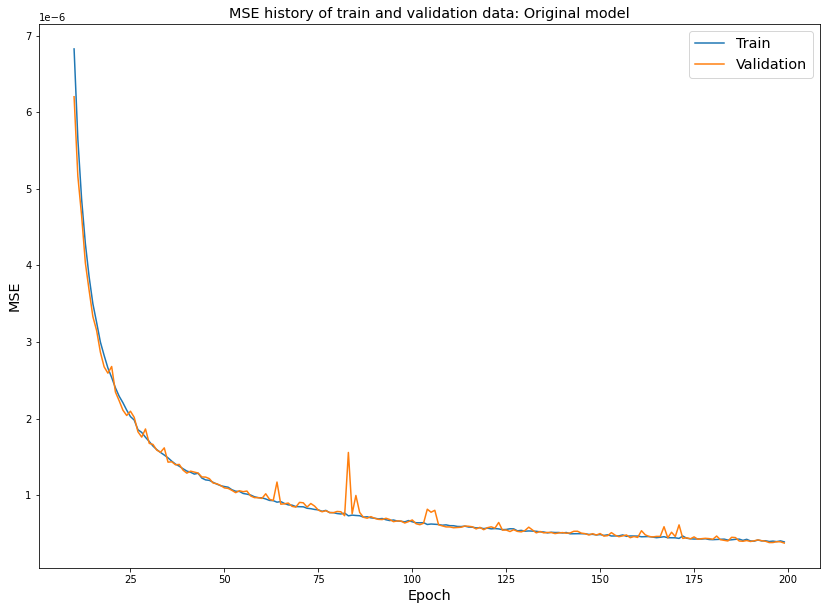

In [12]:
plot_loss(final_hist['loss'][10:], final_hist['val_loss'][10:], 'MSE')

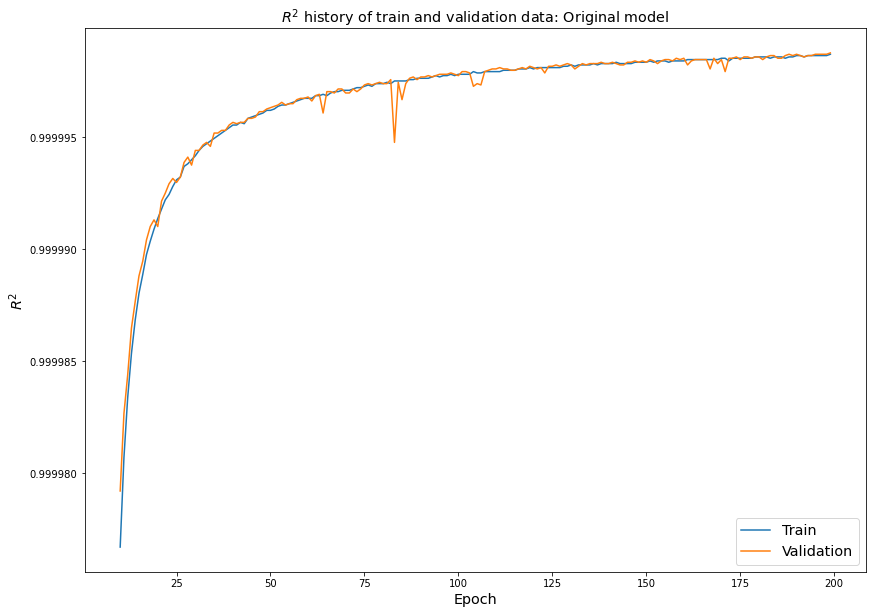

In [13]:
plot_metr(final_hist['r_square'][10:], \
          final_hist['val_r_square'][10:], '$R^2$')

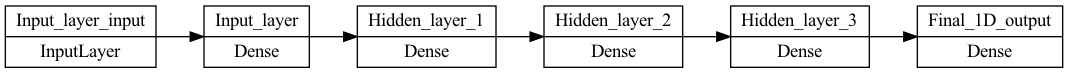

In [14]:
plot_model(final_model_arch, 
           to_file='images/final_models/model_final.png', 
           rankdir='LR',
    #show_shapes=True,
    show_layer_names=True,
)

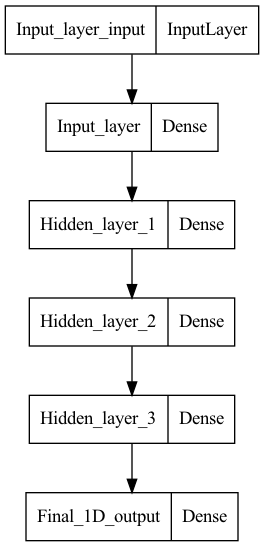

In [15]:
plot_model(final_model_arch, to_file='images/final_models/model_v_final.png')

## Evaluation

In [16]:
final_model.compile(optimizer=Adam(learning_rate = output['lr_0']),loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)

In [17]:
final_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=output['batch_size'],
    callbacks=callbacks,
    return_dict=True
)



2022-05-27 19:46:39.592571: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


391/391 [==============================] - 4s 10ms/step - loss: 4.6238e-07 - r_square: 1.0000


{'loss': 4.623773577350221e-07, 'r_square': 0.9999985098838806}

In [18]:
start = datetime.now()
preds = final_model.predict(
    x=X_test,
    batch_size=output['batch_size'],
    callbacks=callbacks
)
end = datetime.now()
print("It takes ", (end-start).total_seconds(), "seconds to compute 200k call prices using the trained DNN.")

It takes  1.02521 seconds to compute 200k call prices using the trained DNN.


/Users/yersivillegas/thesis/env/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


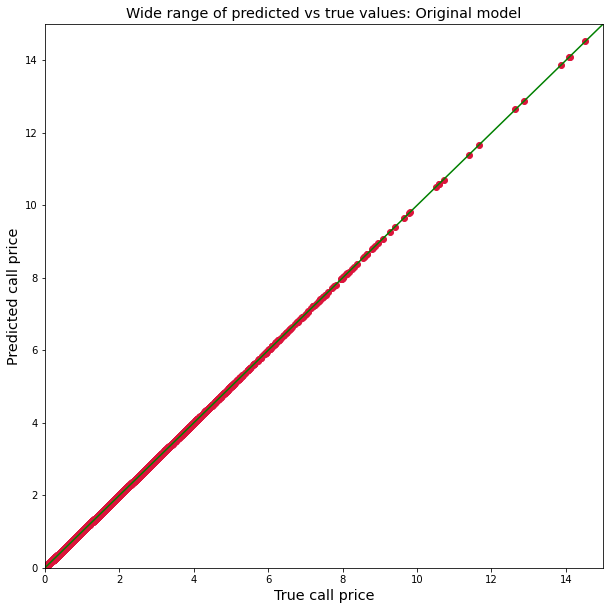

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(y_test), preds, c='crimson')
p1 = max(max(preds), max(np.array(y_test)))
p2 = min(min(preds), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel('True call price',fontsize='x-large')
plt.ylabel('Predicted call price',fontsize='x-large')
plt.title('Wide range of predicted vs true values: Original model',fontsize='x-large')
plt.xlim((0,15))
plt.ylim((0,15))
#plt.axis('equal')
plt.show()

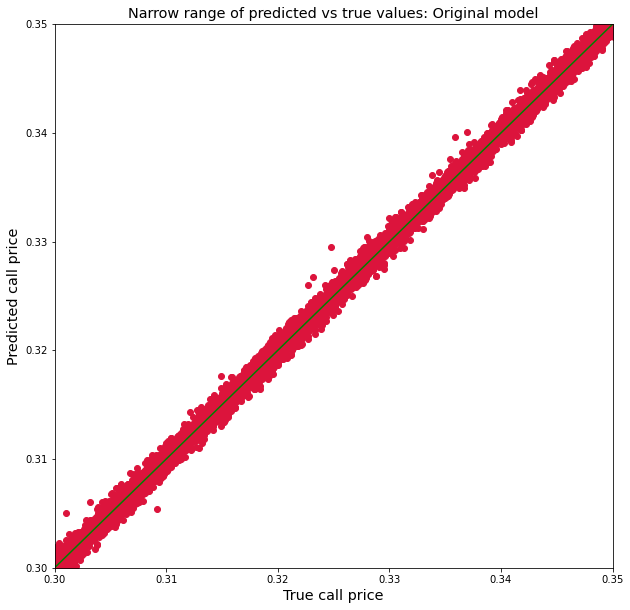

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(y_test), preds, c='crimson')
p1 = max(max(preds), max(np.array(y_test)))
p2 = min(min(preds), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel('True call price',fontsize='x-large')
plt.ylabel('Predicted call price',fontsize='x-large')
plt.title('Narrow range of predicted vs true values: Original model',fontsize='x-large')
plt.xlim((0.3,0.35))
plt.ylim((0.3,0.35))
#plt.axis('equal')
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

mape = mean_absolute_percentage_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print("{:.2e}".format(mape),"{:.2e}".format(mae))

8.70e-02 4.55e-04


In [22]:
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("{:.2e}".format(mse),"{:.2e}".format(np.sqrt(mse)),"{:.2e}".format(r2))

4.62e-07 6.80e-04 1.00e+00


# Running time of 200k call prices under the BS model

## Apply

In [23]:
time_200k = data[['r','sigma','tau','asset','k']][:200000]
time_200k.head()

,r,sigma,tau,asset,k
0,0.05,0.05,0.10,10.000000,10.0
1,0.05,0.05,0.09,9.977024,10.0
2,0.05,0.05,0.08,9.979236,10.0
3,0.05,0.05,0.07,10.085137,10.0
4,0.05,0.05,0.06,9.964273,10.0


In [25]:
def bsmodel(r,sigma,tau,asset,K):
    d1= (np.log(asset/K)+(r+(0.5)*(sigma**2))*(tau)) / (sigma*np.sqrt(tau))
    d2= (np.log(asset/K)+(r+(-1)*(0.5)*(sigma**2))*(tau)) / (sigma*np.sqrt(tau))
    c = asset*(norm(0,1).cdf(d1))-K*np.exp(-1*r*(tau))*(norm(0, 1).cdf(d2))
    return c

In [51]:
start_2 = datetime.now()
time_200k['call_time'] = time_200k.apply(lambda x: bsmodel(x['r'], x['sigma'], x['tau'],\
                                                          x['asset'], x['k']), axis=1)
end_2 = datetime.now()
print("It takes ", (end_2-start_2).total_seconds(), "seconds to compute 200k call prices using the BS model.")

It takes  162.033243 seconds to compute 200k call prices using the BS model.


## Map (aquí Marca :) )

In [27]:
start_3 = datetime.now()

time_200k['call_time'] = list(map(bsmodel, time_200k['r'], time_200k['sigma'], \
                                  time_200k['tau'], time_200k['asset'], time_200k['k']))
end_3 = datetime.now()
print("It takes ", (end_3-start_3).total_seconds(), "seconds to compute 200k call prices using the BS model.")

It takes  165.306916 seconds to compute 200k call prices using the BS model.
